In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sn

# 1. Visualisation des données

In [2]:
globalVisionData = pd.read_csv('data/train.csv')
display(globalVisionData.head())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
globalVisionData.shape

(10886, 12)

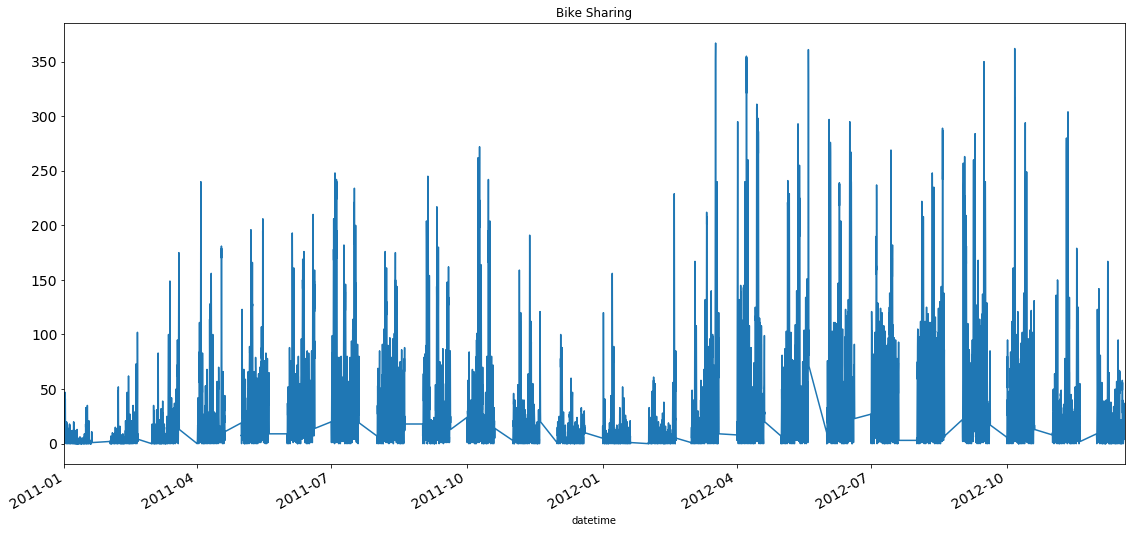

In [4]:
globalVisionData.datetime = pd.to_datetime(globalVisionData.datetime)
globalVisionData.index = globalVisionData.datetime

globalVisionData.casual.plot(figsize=(19,9), title="Bike Sharing", fontsize=14)
plt.show()

# 2. Transformation des données

##   2.1. Importation des données

In [5]:
dataTrain = pd.read_csv('data/train.csv') # 1 au 19 du mois (avec count)
dataTest = pd.read_csv('data/test.csv') # 19 à fin du mois (sans count)

`data` va correspondre à la concaténation de `dataTrain` et `dataTest` (soit l'ensemble des dates).

In [6]:
data = dataTrain.append(dataTest)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

## 2.2. Ajouts de nouvelles colonnes

La date va être découpée en plusieurs colonnes correspondantes chacunes à une unité temporelle

In [7]:
import calendar
from datetime import datetime

data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

## 2.3. Classification des attributs

Nous avons donc 3 types de valeurs différentes:
- Les attributs que l'on nomme `categoricalAttributeNames`: ce sont des entiers qui représentent des catégories (par exemple, season=1 représente le premier quart de l'année).
- les attributs numériques que l'on nomme `numericalAttributeNames`: ce sont des float qui représente une mesure numérique.
- les attributs qu'on ne souhaite pas conserver dans l'entrainement du model (que l'on nomme) `dropAttributes` car:
    - ce sont les attributs que l'on souhaite prédire (l'attribut count)
    - ce sont des attributs redondants (par exemple datetime)

In [8]:
categoricalAttributeNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalAttributeNames = ["temp","humidity","windspeed","atemp"]
dropAttributes = ['casual',"count","datetime","date","registered"]

print(data.dtypes)

atemp         float64
casual        float64
count         float64
datetime       object
holiday         int64
humidity        int64
registered    float64
season          int64
temp          float64
weather         int64
windspeed     float64
workingday      int64
date           object
hour            int64
year           object
weekday         int64
month           int64
dtype: object


Via la librairie `pandas`, on cast le type d'attribut vers `category` pour tous les attributs de la liste `categoricalAttributeNames`

In [9]:
for var in categoricalAttributeNames:
    data[var] = data[var].astype("category")

# 3. Prédiction

## 3.1. RMSLE Scorer

Afin de juger de la qualité de nos prédictions pour chacun des différents modèles, on définit un RSMLE scorer :

In [10]:
def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

Ce scorer exprime de la valeur de la dissimilarité entre notre prédiction (attribut `y`) et les valeurs réelles (attribut `y_`).

## 3.2. Séparation des données d'entraînement et de test 

Pour entrainer le modèle, on re-divise `data` en `dataTrain` (là où on connait l'attribut count) et `dataTest` (là où on doit prédire l'attribut count)

In [11]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]

## 3.3. Division des données d'entrainement

On souhaite mettre en place un apprentissage supervisé.
Ainsi, on divise `dataTrain` de cette façon :
    - 70% pour l'entraînement
    - 30% pour la validation
    
On utilise scikit-learn et la fonction `train_test_split()` pour séparer ces données.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(dataTrain, yLabels, test_size=0.3, random_state=23)

## 3.4. Suppression d'attributs

On supprime les attributs contenus dans la liste `dropAttributes`

In [13]:
dataTrain  = dataTrain.drop(dropAttributes,axis=1)
dataTest  = dataTest.drop(dropAttributes,axis=1)
X_train = X_train.drop(dropAttributes,axis=1)
X_validate = X_validate.drop(dropAttributes,axis=1)

## 3.5. Création du Modèle de régression linéaire

Dans un premier temps, on initialise et on entraine le modèle avec `X_train` et `y_train` (70% des données d'entrainement).

In [14]:
from sklearn.linear_model import LinearRegression

# Initialisation du modèle
lModel = LinearRegression()

# Entrainement du modèle sur 70%
lModel.fit(X = X_train,y = np.log1p(y_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Ensuite, on prédit grâce au modèle les 30%.

In [15]:
# Prédiction sur les 30%
preds = lModel.predict(X=X_validate)

On applique notre RMSLE Scorer pour connaitre la validité du modèle :

In [16]:
print ("RMSLE Value For Linear Regression: ", rmsle(y_validate, np.exp(preds)))

RMSLE Value For Linear Regression:  1.022997786210461


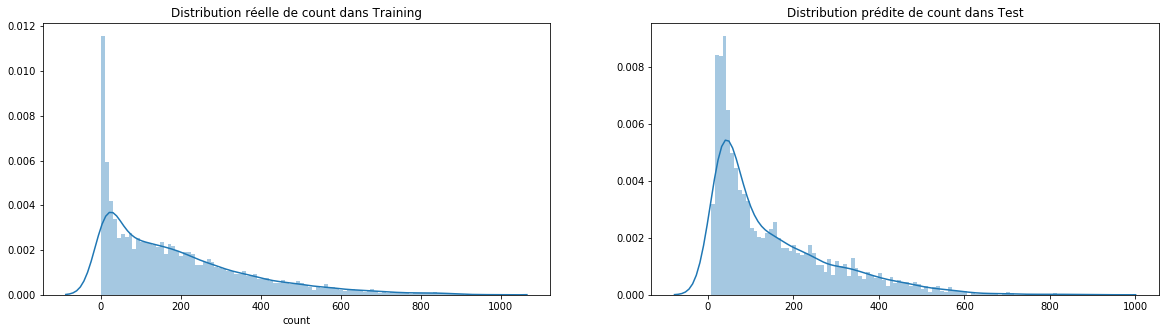

In [17]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.distplot(yLabels, ax=ax1, bins=100)
sn.distplot(np.exp(preds), ax=ax2, bins=100)
ax1.set(title="Distribution réelle de count dans Training")
ax2.set(title="Distribution prédite de count dans Test")
plt.show()

On constate que la distribution entre le set de train et de test varit énorménement.

## 3.6. Utilisation du Modèle de régression linéaire

On utilise ce modèle pour prédire l'attribut count de `test.csv` (soit `dataTest`).

In [18]:
preds = lModel.predict(X=dataTest)

Enfin, on visualise le graphique entier de count avec une couleur différente pour les valeurs données et celles prédites.

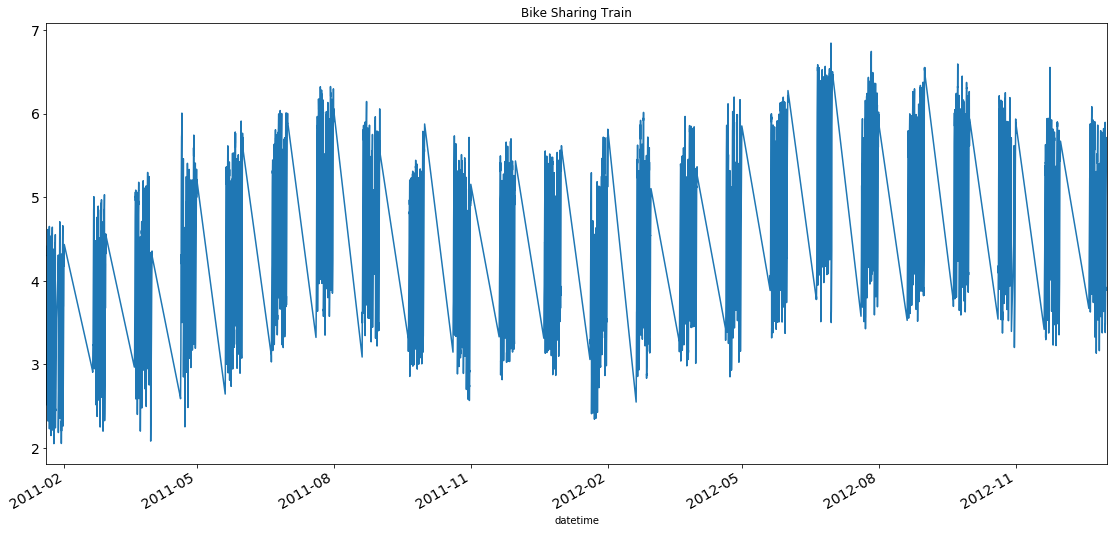

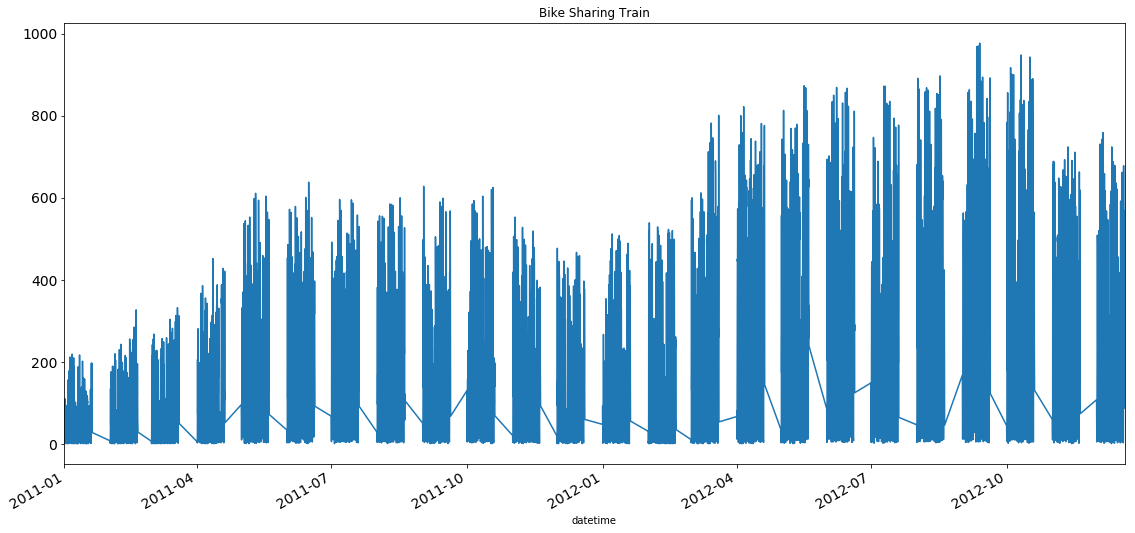

In [19]:
dTrain = pd.read_csv('data/train.csv') # 1 au 19 du mois (avec count)
dTrain.datetime = pd.to_datetime(dTrain.datetime)
dTrain.index = dTrain.datetime

dTest = pd.read_csv('data/test.csv') # 19 à fin du mois (sans count)
dTest.datetime = pd.to_datetime(dTest.datetime)
dTest.index = dTest.datetime

dTest["count"] = preds

dTest['count'].plot(figsize=(19,9), title="Bike Sharing Train", fontsize=14)
plt.show()

dTrain['count'].plot(figsize=(19,9), title="Bike Sharing Train", fontsize=14)
plt.show()

## 3.5. Création du Modèle de régression logistique

In [20]:
from sklearn.ensemble import RandomForestRegressor

# Initialisation du modèle
rfModel = RandomForestRegressor()

# Entrainement du modèle sur 70%
rfModel.fit(X = X_train,y = y_train)

# Prédiction sur les 30%
preds = rfModel.predict(X=X_validate)

print ("RMSLE Value for Random Forest: ", rmsle(y_validate, preds))

RMSLE Value for Random Forest:  0.35524215919878016


## 3.6. Utilisation du Modèle de régression linéaire

On utilise ce modèle pour prédire l'attribut count de `test.csv` (soit `dataTest`).

In [21]:
preds = rfModel.predict(X=dataTest)

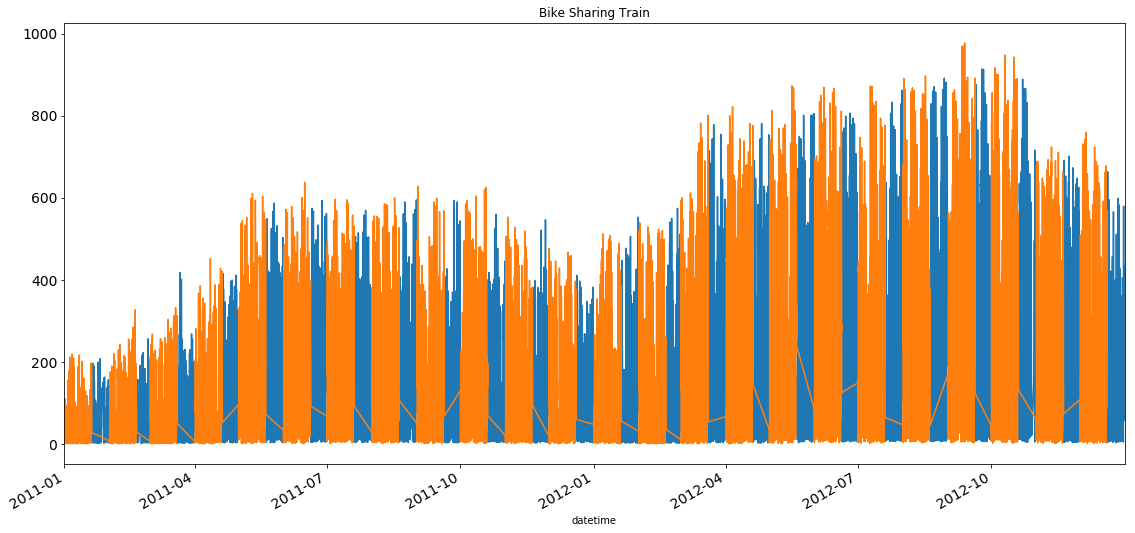

In [22]:
dTrain = pd.read_csv('data/train.csv') # 1 au 19 du mois (avec count)
dTrain.datetime = pd.to_datetime(dTrain.datetime)
dTrain.index = dTrain.datetime

dTest = pd.read_csv('data/test.csv') # 19 à fin du mois (sans count)
dTest.datetime = pd.to_datetime(dTest.datetime)
dTest.index = dTest.datetime

dTest["count"] = preds

dTest['count'].plot(figsize=(19,9), title="Bike Sharing Test", fontsize=14)
dTrain['count'].plot(figsize=(19,9), title="Bike Sharing Train", fontsize=14)
plt.show()

# Gradient Boosting

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gbm = GradientBoostingRegressor()

param_grid = { 
    'n_estimators': [100],
    'max_features': ["auto","sqrt","log2",0.6,0.8],
    'min_samples_leaf':[30,40,50,60,70],
    'min_samples_split':[150,200,250,300],
    'max_depth' : [10,15,20,25],
    'subsample': [0.4,0.6,0.8],
    'learning_rate':[0.1,0.01,0.001]
}
CV_gbm=GridSearchCV(estimator=gbm,param_grid=param_grid,cv=5)
CV_gbm.fit(X = X_train,y = np.log1p(y_train))
print (CV_gbm.best_params_)
preds = CV_gbm.predict(X= X_validate)
print ("RMSLE Value: ",rmsle(y_validate,np.exp(preds)))

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gbm = GradientBoostingRegressor()

gbm.fit(X = X_train,y = np.log1p(y_train))
preds = gbm.predict(X= X_validate)
print ("RMSLE Value: ",rmsle(y_validate,np.exp(preds)))

RMSLE Value:  0.3996840738860082


# 4. Création de submission.csv

On crée un fichier de submission en utilisant le template utilisé par Kaggle en y ajoutant nos résultats pour count.
On sauvegarde ce fichier dans le dossier /submissions/ avec un nom daté.

In [23]:
import datetime
from time import strftime
now = datetime.datetime.now()
now = datetime.datetime.strftime(now, '%Y-%m-%d_%H:%M')

submission = pd.read_csv('data/submission.csv')
submission["count"] = preds

submission.to_csv('submissions/submission_'+now, index=False)